This is a notebook for SVM model.

##Installations

###Download prepared dataset

split_v3:
https://drive.google.com/file/d/1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu/view?usp=drive_link

In [47]:
!gdown 1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu

Downloading...
From: https://drive.google.com/uc?id=1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu
To: /content/splits_v3.zip
100% 476M/476M [00:03<00:00, 141MB/s] 


In [48]:
!unzip splits_v3.zip

Archive:  splits_v3.zip
replace splits_v3/validation/glass/glass_674.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

###Read files

Since the dataset has been prepared (chosen, resized, splitted), just get each available set (train, validation, test)

In [49]:
import os
import numpy as np
import cv2

The labels for each set are the same, so just reuse it:

In [50]:
labels = sorted(os.listdir('/content/splits_v3/train'))

In [51]:
labels

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

####Get train set

In [52]:
train = dict()

for label in labels:
    img_paths = list(os.listdir('./splits_v3/train/' + label))
    img_paths = map(lambda p: f'./splits_v3/train/{label}/{p}', img_paths)
    train[label] = []
    for path in img_paths:
        img = cv2.imread(path)
        train[label].append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [53]:
X_train = []
y_train = []

for encoded_label, label in enumerate(labels):
    y_train += [encoded_label] * len(train[label])
    X_train += train[label]

In [54]:
y_train = np.array(y_train)
X_train = np.array(X_train)

Check train set:

In [55]:
y_train.shape

(3260,)

In [56]:
X_train.shape

(3260, 300, 400, 3)

####Get validation set

In [57]:
validation = dict()

for label in labels:
    img_paths = list(os.listdir('./splits_v3/validation/' + label))
    img_paths = map(lambda p: f'./splits_v3/validation/{label}/{p}', img_paths)
    validation[label] = []
    for path in img_paths:
        img = cv2.imread(path)
        validation[label].append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [58]:
X_dev = []
y_dev = []

for encoded_label, label in enumerate(labels):
    y_dev += [encoded_label] * len(validation[label])
    X_dev += validation[label]

In [59]:
y_dev = np.array(y_dev)
X_dev = np.array(X_dev)

Check validation set:

In [60]:
y_dev.shape

(699,)

In [61]:
X_dev.shape

(699, 300, 400, 3)

####Get test set

In [62]:
test = dict()

for label in labels:
    img_paths = list(os.listdir('./splits_v3/test/' + label))
    img_paths = map(lambda p: f'./splits_v3/test/{label}/{p}', img_paths)
    test[label] = []
    for path in img_paths:
        img = cv2.imread(path)
        test[label].append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [63]:
X_test = []
y_test = []

for encoded_label, label in enumerate(labels):
    y_test += [encoded_label] * len(test[label])
    X_test += test[label]

In [64]:
y_test = np.array(y_test)
X_test = np.array(X_test)

Check test set:

In [27]:
y_test.shape

(699,)

In [28]:
X_test.shape

(699, 300, 400, 3)

##Feature Engineering

Using SIFT technique for Feature Engineering

In [29]:
def extract_sift_features(X):
  image_descriptors = []
  sift = cv2.xfeatures2d.SIFT_create()
  for i in range(len(X)):
      _, des = sift.detectAndCompute(X[i], None)
      image_descriptors.append(des)
  return image_descriptors

In [67]:
from sklearn.cluster import KMeans
import pickle
def kmean_bow(all_descriptors, num_cluster):
    bow_dict = []

    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    return bow_dict

In [66]:
from scipy.spatial.distance import cdist
def create_feature_bow(image_descriptors, BoW, num_cluster):

    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)

            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1
        X_features.append(features)

    return X_features

In [88]:
X_train_ex = np.array(extract_sift_features(X_train))
X_dev_ex = np.array(extract_sift_features(X_dev))
X_test_ex = np.array(extract_sift_features(X_test))

<ipython-input-88-de376d6e2df3>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_ex = np.array(extract_sift_features(X_train))
<ipython-input-88-de376d6e2df3>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_dev_ex = np.array(extract_sift_features(X_dev))
<ipython-input-88-de376d6e2df3>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

In [93]:
all_descriptors = []
for descriptor in X_train_ex:
    if descriptor is not None:
        for des in descriptor:
            all_descriptors.append(des)


In [94]:
BoW = kmean_bow(all_descriptors, 300)

In [111]:
if not os.path.isfile('bow_dictionary.pkl'):
        pickle.dump(BoW, open('bow_dictionary.pkl', 'wb'))

In [115]:
X_train_ft = create_feature_bow(X_train_ex, BoW, 300)

In [119]:
X_dev_ft = create_feature_bow(X_dev_ex, BoW, 300)

In [120]:
X_test_ft = create_feature_bow(X_test_ex, BoW, 300)

##Hyperparameter Tuning

In [125]:
X_train_ft = np.array(X_train_ft)

In [171]:
X_dev_ft = np.array(X_dev_ft)

In [132]:
del X_dev, X_dev_ex, X_test, X_test_ex, X_train, X_train_ex

In [133]:
del images, test, train, validation

In [138]:
del all_descriptors, des, descriptor

In [140]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [174]:
X_train_ft

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 7],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 2, 0, ..., 0, 0, 1],
       [4, 1, 5, ..., 3, 4, 2],
       [1, 1, 0, ..., 0, 0, 1]])

In [179]:
X_traindev = np.concatenate([X_train_ft, X_dev_ft], axis = 0)

In [182]:
y_traindev = np.concatenate([y_train, y_dev], axis = 0)

In [185]:
param_grid = {'C': np.logspace(-2, 7, 10),
              'gamma': np.logspace(-9, -3, 7),
              'kernel': ['rbf']}

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.1275, random_state=42)

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=cv)

grid.fit(X_traindev, y_traindev)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[CV 1/3] END ...C=0.01, gamma=1e-09, kernel=rbf;, score=0.154 total time=   6.6s
[CV 2/3] END ...C=0.01, gamma=1e-09, kernel=rbf;, score=0.154 total time=   4.7s
[CV 3/3] END ...C=0.01, gamma=1e-09, kernel=rbf;, score=0.154 total time=   5.8s
[CV 1/3] END ...C=0.01, gamma=1e-08, kernel=rbf;, score=0.154 total time=   6.1s
[CV 2/3] END ...C=0.01, gamma=1e-08, kernel=rbf;, score=0.154 total time=   6.5s
[CV 3/3] END ...C=0.01, gamma=1e-08, kernel=rbf;, score=0.154 total time=   5.0s
[CV 1/3] END ...C=0.01, gamma=1e-07, kernel=rbf;, score=0.154 total time=   5.4s
[CV 2/3] END ...C=0.01, gamma=1e-07, kernel=rbf;, score=0.154 total time=   5.5s
[CV 3/3] END ...C=0.01, gamma=1e-07, kernel=rbf;, score=0.154 total time=   5.3s
[CV 1/3] END ...C=0.01, gamma=1e-06, kernel=rbf;, score=0.154 total time=   6.0s
[CV 2/3] END ...C=0.01, gamma=1e-06, kernel=rbf;, score=0.154 total time=   4.7s
[CV 3/3] END ...C=0.01, gamma=1e-06, kernel=rbf

The best parameters are {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'} with a score of 0.53

##Create a model

In [186]:
clf = SVC(C=10, gamma=0.001, kernel='rbf')

In [187]:
clf.fit(X_train_ft, y_train)

SVC(C=10, gamma=0.001)

##Prediction

In [189]:
X_test_ft = np.array(X_test_ft)

In [190]:
y_pred = clf.predict(X_test_ft)

##Evaluation metrics

In [191]:
from sklearn import metrics
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, y_pred)}\n"
)

Classification report for classifier SVC(C=10, gamma=0.001):
              precision    recall  f1-score   support

           0       0.58      0.57      0.58        93
           1       0.67      0.73      0.70       109
           2       0.44      0.42      0.43        88
           3       0.52      0.47      0.49       102
           4       0.57      0.67      0.62        98
           5       0.38      0.50      0.43       101
           6       0.52      0.30      0.38       108

    accuracy                           0.52       699
   macro avg       0.52      0.52      0.52       699
weighted avg       0.53      0.52      0.52       699




Confusion matrix:
[[53  4  6  5 12 11  2]
 [ 6 80  4  5  2  8  4]
 [ 6  4 37 16  4 13  8]
 [ 2  6 14 48 10 20  2]
 [12  2  0  4 66  9  5]
 [ 5  7 15 11  4 50  9]
 [ 7 16  9  4 18 22 32]]


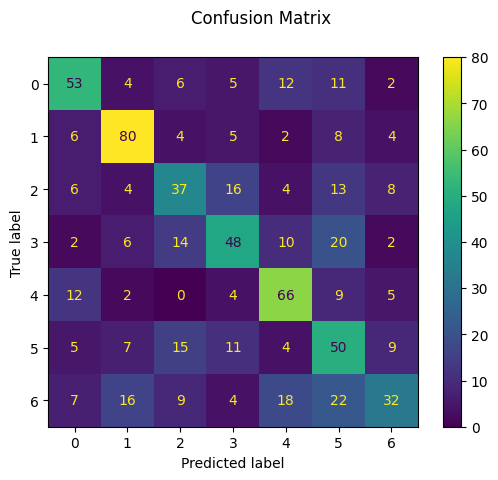

In [192]:
import matplotlib.pyplot as plt
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [193]:
labels

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']